# Warehouse Slotting - Run 1

## Steps:
    1) Load sales order data
    2) Run Association rules - Apriori
    3) Analysis of Apriori results
    4) Run LP model 1 - Popularity based
    5) Run NLP model 2 - Affinity based
    6) Run picking simulation for model 1
    7) Run picking simulation for model 2
    8) Run NLP model 3 - Hybrid
    9) Run picking simulation for model 3
    10) Import AS-IS warehouse product arrangement
    11) Run picking simulation for AS-IS
    12) Compare models 1, 2, 3 and AS-IS     

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

# Step 1 : Load sales order file

In [2]:
df_salesOrder = pd.read_excel('Input Data/Sales Orders.xlsx')
df_salesOrder['SALES_ORDER'] = df_salesOrder['SALES_ORDER'].astype('str')
df_salesOrder.head()

,Plant,MATERIAL_NUMBER,SALES_ORDER,SALES_ORDER_ITEM,SALES_ORDER_ITEM_CREATE_DATE_FISCAL_WEEK,SALES_ORDER_ITEM_CREATE_DATE_FISCAL_YEAR,SCHEDULE_QUANTITY
0,WH1,ITM3249,29273582,50,7,2022,1
1,WH1,ITM6,29273582,30,7,2022,1
2,WH1,ITM3249,29273582,20,7,2022,1
3,WH1,ITM2103,29311350,440,8,2022,1
4,WH1,ITM2103,29311350,310,8,2022,1


### Order Frequency

In [3]:
df_salesOrder['MATERIAL_NUMBER'].value_counts()

ITM2103    3422
ITM5010    1069
ITM742      734
ITM5011     562
ITM1130     557
           ... 
ITM6448       1
ITM1644       1
ITM6902       1
ITM4495       1
ITM6728       1
Name: MATERIAL_NUMBER, Length: 3180, dtype: int64

### Order freq after removing material-sales order duplicates

In [4]:
df = df_salesOrder[['MATERIAL_NUMBER', 'SALES_ORDER']].drop_duplicates()
df['MATERIAL_NUMBER'].value_counts().to_frame()

,MATERIAL_NUMBER
ITM742,674
ITM5010,576
ITM1130,553
ITM2103,523
ITM157,463
...,...
ITM84,1
ITM4582,1
ITM6634,1
ITM2018,1


In [5]:
Order_freq = df_salesOrder['MATERIAL_NUMBER'].value_counts().to_frame()
Order_freq = Order_freq.reset_index()
Order_freq = Order_freq.rename(columns={"MATERIAL_NUMBER": "Order Count", "index": "MATERIAL_NUMBER"})
Order_freq.head()

,MATERIAL_NUMBER,Order Count
0,ITM2103,3422
1,ITM5010,1069
2,ITM742,734
3,ITM5011,562
4,ITM1130,557


In [6]:
distinctOrder_freq = df['MATERIAL_NUMBER'].value_counts().to_frame()
distinctOrder_freq = distinctOrder_freq.reset_index()
distinctOrder_freq = distinctOrder_freq.rename(columns={"MATERIAL_NUMBER": "Order Count", "index": "MATERIAL_NUMBER"})
distinctOrder_freq.head()

,MATERIAL_NUMBER,Order Count
0,ITM742,674
1,ITM5010,576
2,ITM1130,553
3,ITM2103,523
4,ITM157,463


In [7]:
df_salesOrder.shape

(68895, 7)

In [8]:
Total_salesOrderLines = df_salesOrder.shape[0]
Total_salesOrderLines

68895

In [9]:
Total_distinct_salesOrders = df_salesOrder.SALES_ORDER.nunique()
Total_distinct_salesOrders

18998

In [10]:
Total_distinct_Products_sold = df_salesOrder.MATERIAL_NUMBER.nunique()
Total_distinct_Products_sold

3180

## Single vs Multiple Line Orders

Text(0.5, 1.0, 'Single vs Multiple Line Orders')

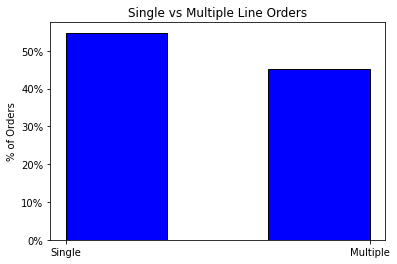

In [11]:
df = df_salesOrder[['MATERIAL_NUMBER', 'SALES_ORDER']].drop_duplicates()
df2 = df.groupby('SALES_ORDER')['MATERIAL_NUMBER'].agg(No_of_Lines='count').reset_index()
df2.loc[df2['No_of_Lines'] == 1, 'Single or Multiple'] = 'Single'
df2.loc[df2['No_of_Lines'] > 1, 'Single or Multiple'] = 'Multiple'

data = df2['Single or Multiple']

from matplotlib.ticker import PercentFormatter
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, edgecolor='black', bins=3, color = 'blue',
        weights=np.ones_like(data)*100 / len(data))
ax.yaxis.set_major_formatter(PercentFormatter())
plt.ylabel('% of Orders')
plt.title('Single vs Multiple Line Orders')

## Split of Multiple Line Orders by No of lines

Text(0.5, 1.0, 'Split of Multiple Line Orders by No of lines')

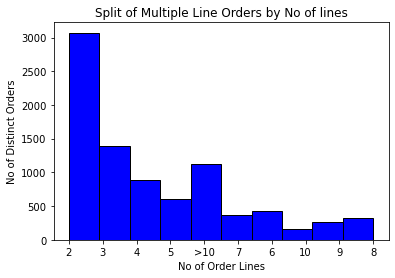

In [12]:
df = df_salesOrder[['MATERIAL_NUMBER', 'SALES_ORDER']].drop_duplicates()
df2 = df.groupby('SALES_ORDER')['MATERIAL_NUMBER'].agg(No_of_Lines='count').reset_index()
df2.loc[df2['No_of_Lines'] == 1, 'Single or Multiple'] = 'Single'
df2.loc[df2['No_of_Lines'] > 1, 'Single or Multiple'] = 'Multiple'

df2.loc[df2['No_of_Lines'] > 10, 'No_of_Lines'] = '>10'
df3 = df2[df2['No_of_Lines'] != 1]
df3['No_of_Lines'] = df3['No_of_Lines'].astype(str)

data = df3['No_of_Lines']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, edgecolor='black', color = 'blue')
plt.ylabel('No of Distinct Orders')
plt.xlabel('No of Order Lines')
plt.title('Split of Multiple Line Orders by No of lines')

#    Step2 : Run Association Rules - Apriori

### Build a basket (like a shopping cart per sales order)

In [13]:
mybasket = (df_salesOrder.groupby(['SALES_ORDER','MATERIAL_NUMBER'])['SCHEDULE_QUANTITY'].
            sum().unstack().reset_index().fillna(0).set_index('SALES_ORDER'))

In [14]:
mybasket.head()

MATERIAL_NUMBER,ITM1,ITM10,ITM100,ITM1000,ITM1002,ITM1004,ITM1006,ITM1007,ITM1012,ITM1017,...,ITM97,ITM98,ITM983,ITM984,ITM985,ITM992,ITM993,ITM994,ITM997,ITM998
SALES_ORDER,,,,,,,,,,,,,,,,,,,,,
27034852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27546143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27546176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27728583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to make basket boolean - product IN or OUT

In [15]:
#Fucntion
def my_encode_units(x):
    if x <= 0:
        return False
    if x > 0:
        return True

mybasket = mybasket.applymap(my_encode_units)

In [16]:
mybasket.head()

MATERIAL_NUMBER,ITM1,ITM10,ITM100,ITM1000,ITM1002,ITM1004,ITM1006,ITM1007,ITM1012,ITM1017,...,ITM97,ITM98,ITM983,ITM984,ITM985,ITM992,ITM993,ITM994,ITM997,ITM998
SALES_ORDER,,,,,,,,,,,,,,,,,,,,,
27034852,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27546143,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27546176,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27728583,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27997929,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Generate frequent itemsets

extract itemsets with minimum support of .1% (lesser than that is noise)

In [17]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
my_freq_items = apriori(mybasket, min_support=.001, use_colnames=True)

### Freq item set:

In [18]:
my_freq_items.sort_values(by=['support'], ascending=False)

,support,itemsets
691,0.035477,(ITM742)
242,0.030319,(ITM5010)
25,0.029108,(ITM1130)
159,0.027529,(ITM2103)
79,0.024371,(ITM157)
...,...,...
1934,0.001000,"(ITM789, ITM1130, ITM6326)"
1010,0.001000,"(ITM5808, ITM157)"
271,0.001000,(ITM5094)
2636,0.001000,"(ITM328, ITM677, ITM3164, ITM5)"


## Run association rules

### minimum Lift value of 1, means extract all rules from itemset

In [19]:
my_rules = association_rules(my_freq_items, metric="lift",min_threshold=1)

In [20]:
my_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ITM1),(ITM1114),0.012107,0.009369,0.001053,0.086957,9.280899,0.000939,1.084976
1,(ITM1114),(ITM1),0.009369,0.012107,0.001053,0.112360,9.280899,0.000939,1.112943
2,(ITM1),(ITM2105),0.012107,0.008580,0.001000,0.082609,9.628221,0.000896,1.080695
3,(ITM2105),(ITM1),0.008580,0.012107,0.001000,0.116564,9.628221,0.000896,1.118241
4,(ITM1),(ITM2769),0.012107,0.007053,0.002474,0.204348,28.971642,0.002389,1.247966


### Sort by antecedent support, consequent support and then confidence
Meaning: sort by Top part, consequent top part, and their confidence

In [21]:
my_rules = my_rules.sort_values(by=['antecedent support', 'consequent support','confidence'], ascending=False)

In [22]:
my_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
191,(ITM742),(ITM1130),0.035477,0.029108,0.008632,0.243323,8.359238,0.007600,1.283100
1328,(ITM742),(ITM5011),0.035477,0.023108,0.010212,0.287834,12.456189,0.009392,1.371720
2216,(ITM742),(ITM677),0.035477,0.021844,0.008580,0.241840,11.071016,0.007805,1.290170
1365,(ITM742),(ITM5012),0.035477,0.021634,0.008632,0.243323,11.247345,0.007865,1.292978
1137,(ITM742),(ITM373),0.035477,0.018949,0.007527,0.212166,11.196480,0.006855,1.245251


In [23]:
my_rules.to_csv('complete_rules.csv', index=False)

In [24]:
df = pd.read_csv('complete_rules.csv')
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,frozenset({'ITM742'}),frozenset({'ITM1130'}),0.035477,0.029108,0.008632,0.243323,8.359238,0.007600,1.283100
1,frozenset({'ITM742'}),frozenset({'ITM5011'}),0.035477,0.023108,0.010212,0.287834,12.456189,0.009392,1.371720
2,frozenset({'ITM742'}),frozenset({'ITM677'}),0.035477,0.021844,0.008580,0.241840,11.071016,0.007805,1.290170
3,frozenset({'ITM742'}),frozenset({'ITM5012'}),0.035477,0.021634,0.008632,0.243323,11.247345,0.007865,1.292978
4,frozenset({'ITM742'}),frozenset({'ITM373'}),0.035477,0.018949,0.007527,0.212166,11.196480,0.006855,1.245251


## Remove antecedents and consequents with multiple products

In [25]:
df = df[df["antecedents"].str.contains(",") == False]
df = df[df["consequents"].str.contains(",") == False]

df['antecedents'] = df['antecedents'].str.replace('frozenset', '')
df['antecedents'] = df['antecedents'].str.replace('{', '')
df['antecedents'] = df['antecedents'].str.replace('}', '')
df['antecedents'] = df['antecedents'].str.replace('(', '')
df['antecedents'] = df['antecedents'].str.replace(')', '')
df['antecedents'] = df['antecedents'].str.replace("'", '')

df['consequents'] = df['consequents'].str.replace('frozenset', '')
df['consequents'] = df['consequents'].str.replace('{', '')
df['consequents'] = df['consequents'].str.replace('}', '')
df['consequents'] = df['consequents'].str.replace('(', '')
df['consequents'] = df['consequents'].str.replace(')', '')
df['consequents'] = df['consequents'].str.replace("'", '')

rules = df
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,ITM742,ITM1130,0.035477,0.029108,0.008632,0.243323,8.359238,0.007600,1.283100
1,ITM742,ITM5011,0.035477,0.023108,0.010212,0.287834,12.456189,0.009392,1.371720
2,ITM742,ITM677,0.035477,0.021844,0.008580,0.241840,11.071016,0.007805,1.290170
3,ITM742,ITM5012,0.035477,0.021634,0.008632,0.243323,11.247345,0.007865,1.292978
4,ITM742,ITM373,0.035477,0.018949,0.007527,0.212166,11.196480,0.006855,1.245251
...,...,...,...,...,...,...,...,...,...
14570,ITM6610,ITM6500,0.001158,0.004316,0.001000,0.863636,200.089800,0.000995,7.301681
14571,ITM6610,ITM1838,0.001158,0.001842,0.001000,0.863636,468.781818,0.000998,7.319823
14596,ITM6418,ITM5011,0.001105,0.023108,0.001105,1.000000,43.275626,0.001080,inf
14646,ITM5650,ITM5652,0.001105,0.003000,0.001053,0.952381,317.426901,0.001049,20.936993


In [26]:
rules.to_csv('product affinity.csv', index=False)

# Step 3: Analyze of Apriori Results

### Histogram of confidence values

Text(0, 0.5, 'No. of Product Pairs')

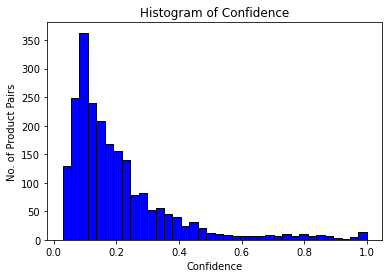

In [27]:
plt.hist(rules['confidence'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(rules['confidence'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Confidence')
plt.xlabel('Confidence')
plt.ylabel('No. of Product Pairs')

Text(0, 0.5, '% of Product Pairs')

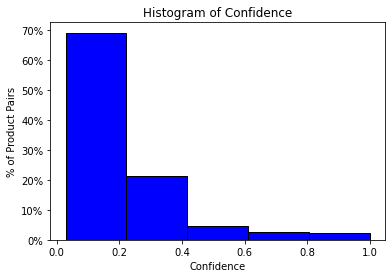

In [28]:
from matplotlib.ticker import PercentFormatter

#define data values
data = rules['confidence']

#create relative frequency histogram with percentages on y-axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data, edgecolor='black', bins=int(100/20), color = 'blue',
        weights=np.ones_like(data)*100 / len(data))
ax.yaxis.set_major_formatter(PercentFormatter())
plt.title('Histogram of Confidence')
plt.xlabel('Confidence')
plt.ylabel('% of Product Pairs')

### Support vs Confidence (scatter plot)

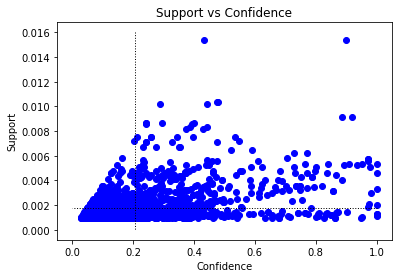

In [29]:
x = rules['confidence']
y = rules['support']

plt.scatter(x, y, c ="blue")
plt.plot([x.mean(),x.mean()],[.016,.000],'k-', linestyle = ":", lw=1)
plt.plot([1,0],[y.mean(),y.mean()],'k-', linestyle = ":", lw=1)
 
# To show the plot
plt.title('Support vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()

In [30]:
top20_materials = distinctOrder_freq.head(20)['MATERIAL_NUMBER'].tolist()
df = rules[rules['antecedents'].isin(top20_materials)]
df = df[df['consequents'].isin(top20_materials)]

## Confidence Heat Map for top 20 products

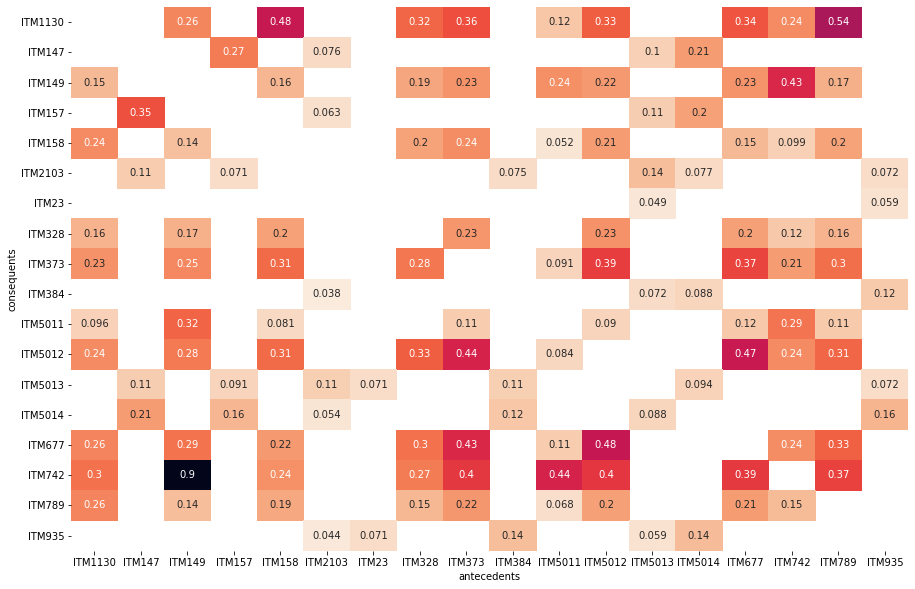

In [31]:
# Transform antecedent, consequent, and support columns into matrix
support_table = df.pivot(index='consequents', columns='antecedents', values='confidence')

plt.figure(figsize=(15,10))
cmap = sns.cm.rocket_r
sns.heatmap(support_table, cmap = cmap, annot=True, cbar=False)
plt.show() 

### Support vs Confidence for Top 20 (scatter plot)

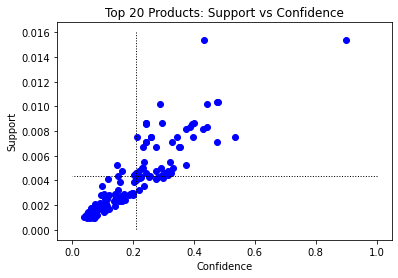

In [32]:
x = df['confidence']
y = df['support']

plt.scatter(x, y, c ="blue")
plt.plot([x.mean(),x.mean()],[.016,.000],'k-', linestyle = ":", lw=1)
plt.plot([1,0],[y.mean(),y.mean()],'k-', linestyle = ":", lw=1)
 
# To show the plot
plt.title('Top 20 Products: Support vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()

## ABC Analysis (Pareto)

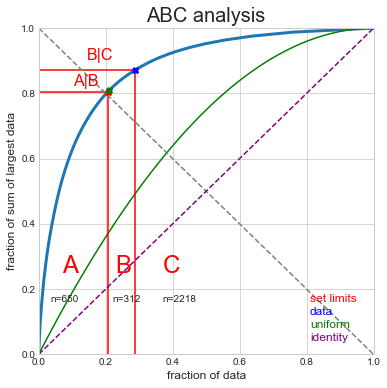

In [33]:
from abc_analysis import abc_analysis, abc_plot
abc = abc_analysis(distinctOrder_freq['Order Count'], True)

### Add ABC classification to product file with order freq

In [34]:
# index position of A, B, and C Videos
a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

# New Column indicating A, B, or C
cond_list = [distinctOrder_freq.index.isin(a_index),
             distinctOrder_freq.index.isin(b_index),
             distinctOrder_freq.index.isin(c_index)]

choice_list = ['A','B','C']

distinctOrder_freq['ABC'] = np.select(cond_list, choice_list)
distinctOrder_freq

,MATERIAL_NUMBER,Order Count,ABC
0,ITM742,674,A
1,ITM5010,576,A
2,ITM1130,553,A
3,ITM2103,523,A
4,ITM157,463,A
...,...,...,...
3175,ITM84,1,C
3176,ITM4582,1,C
3177,ITM6634,1,C
3178,ITM2018,1,C


### Support vs Confidence for Class-A parts (scatter plot)

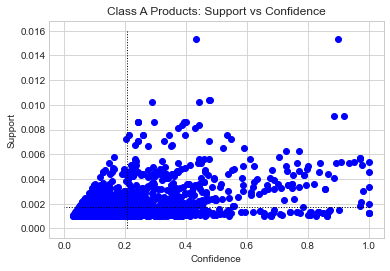

In [35]:
cnt_A = int(distinctOrder_freq[distinctOrder_freq['ABC']=='A'].MATERIAL_NUMBER.count())
Class_A_materials = distinctOrder_freq.head(cnt_A)['MATERIAL_NUMBER'].tolist()
df = rules[rules['antecedents'].isin(Class_A_materials)]
df = df[df['consequents'].isin(Class_A_materials)]

x = df['confidence']
y = df['support']

plt.scatter(x, y, c ="blue")
plt.plot([x.mean(),x.mean()],[.016,.000],'k-', linestyle = ":", lw=1)
plt.plot([1,0],[y.mean(),y.mean()],'k-', linestyle = ":", lw=1)
 
# To show the plot
plt.title('Class A Products: Support vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()

## Load Product Dimensions

In [36]:
Product_dims = pd.read_excel('Input Data/Product dims.xlsx')

/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


### Compute Number of locations needed

In [37]:
import math

STD_LOC_VOL = (46 * 48 * 60) * .8
nbrOfdays = 18 * 7
DaysOfSupply = 3
df = distinctOrder_freq
product = df['MATERIAL_NUMBER'].values.tolist()

distinctOrder_freq['PICK_FACE_NO_OF_LOC'] = 1

for ind, rec in Product_dims.iterrows():
    p = rec['Material']
    vol = 0.0
    if rec['Volume Cubic Unit'] == 'IN':
        vol = rec['Volume']
    elif rec['Volume Cubic Unit'] == 'CM':
        vol = rec['Volume'] * (0.393701)**3.0
    elif rec['Volume Cubic Unit'] == 'MM':
        vol = rec['Volume'] * (0.0393701)**3
    elif rec['Volume Cubic Unit'] == 'M':
        vol = rec['Volume'] * (39.3701)**3
    if vol > 0.0:
        if p in product:
            avg_demand = df[df['MATERIAL_NUMBER'] == p]['Order Count'] /nbrOfdays * DaysOfSupply
            distinctOrder_freq.loc[distinctOrder_freq['MATERIAL_NUMBER'] == p,
                                   'PICK_FACE_NO_OF_LOC'] = int(math.ceil(avg_demand*vol/STD_LOC_VOL))

distinctOrder_freq[distinctOrder_freq['PICK_FACE_NO_OF_LOC'] > 1]

,MATERIAL_NUMBER,Order Count,ABC,PICK_FACE_NO_OF_LOC
43,ITM6182,203,A,3


### Only one item above needs more than one location. Not a useful input

In [38]:
distinctOrder_freq.to_csv('Products.csv',index=False)

In [39]:
Products = pd.read_csv('Products.csv')

## Load Locations file
It contains all locations and its distance to drop-off and Pick-Distance (distance while traveling in pick sequence)

In [40]:
Locations = pd.read_excel('Input Data/Location Distances.xlsx')

/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [41]:
Locations.head()

,Location,Aisle,Bin Position,Level,Storage Type,Oneway Pick Distance,Factored Vertical Distance,Final Pick Distance,Distance to dropoff,Final distance to drop off,Sort Field
0,50.54.A,50,54,A,PCK,0.000000,0.0,0.000000,18.000000,18.000000,1
1,50.54.B,50,54,B,OVR,0.000000,18.5,18.500000,18.000000,36.500000,2
2,50.54.C,50,54,C,OVR,0.000000,37.0,37.000000,18.000000,55.000000,3
3,50.54.D,50,54,D,OVR,0.000000,55.5,55.500000,18.000000,73.500000,4
4,50.53.A,50,53,A,PCK,4.041667,0.0,4.041667,22.041667,22.041667,9


# Tada!!  Time to Run LP Model 1

## INPUT PARAMS FOR RUN 1:
### No_of_Products = 20
### No_of_Locations = 108  (Rack 54 and 49)
### No_of_Loc_per_product = 1
### locations = Locations[Locations['Level']=='A'].head(No_of_Locations)  - Only care for ground locations aka pickfaces

Change input params for Run2, 3 and 4:
Run 2:
No_of_Products = 50
No_of_Locations = 216 

Run 3:
No_of_Products = 100
No_of_Locations = 216

Run 4:
No_of_Products = 215
No_of_Locations = 216

In [42]:
No_of_Products = 20
product = Products.head(No_of_Products)['MATERIAL_NUMBER'].values.tolist()
No_of_Locations = 108
No_of_Loc_per_product = 1
locations = Locations[Locations['Level']=='A'].head(No_of_Locations)
locations = locations.sort_values(by=['Final distance to drop off', 'Final Pick Distance','Sort Field'], 
                                  ascending=True)
location = locations['Location'].values.tolist()

###  Build location to location distance matrix 
(calling it matrix, actually dictionary)

In [43]:
same_aisle = [{50,49},{48,47},{46,45},{44,43},{42,41},{40,39},{38,37},{36,35},
              {34,33},{32,31},{30,29},{28,27},{26,25},{24,23},{22,21},{20,19},
              {18,17},{16,15},{14,13},{12,11},{10,9},{8,7},{6,5},{4,3},{2,1}]
distance_Pick = pd.Series(locations['Final Pick Distance'].values,index=locations.Location).to_dict()
distance_IO = pd.Series(locations['Final distance to drop off'].values,index=locations.Location).to_dict()
distance_BTW = defaultdict(dict)
for l1 in location:
    distance_BTW[l1] = defaultdict(dict)
    for l2 in location:
        a1 = int(l1[:2])
        a2 = int(l2[:2])
        if {a1,a2} in same_aisle:
            if a1 > a2:
                d1 = distance_Pick[l1]
                d2 = distance_Pick[l2] - 12
            else:
                d1 = distance_Pick[l1] - 12
                d2 = distance_Pick[l2]
            distance_BTW[l1][l2] = abs(d1-d2) + 12
        else:
            distance_BTW[l1][l2] = abs(distance_Pick[l1] - distance_Pick[l2])

#list(distance_BTW.items())[:1]

# Step 4 : Run LP model 1 - Popularity based

In [44]:
##STAGE 1
from pyomo.environ import *

noOfPrd = len(product)
supply = dict(zip(product, [No_of_Loc_per_product]*noOfPrd))

noOfLoc = len(location)
demand = dict(zip(location, [1]*noOfLoc))

orderFreq_dict = pd.Series(Products['Order Count'].values,index=Products.MATERIAL_NUMBER).to_dict()

supply["DUMMY_PART"] = 0
diff = sum(demand.values()) - sum(supply.values()) #comparing supply and demand
if 'DUMMY_PART' not in product:
    product.append("DUMMY_PART")
supply["DUMMY_PART"] = diff
orderFreq_dict["DUMMY_PART"] = 0

# instantiate Concrete Model
model = ConcreteModel()

# define variables
model.X = Var(product, location, domain=NonNegativeReals)

# define objective function
model.total_distance = Objective(expr=sum(orderFreq_dict[p] * distance_IO[l] * model.X[p, l]
                                     for p in product 
                                     for l in location), 
                            sense=minimize)

# define constraints
model.supply_ct = ConstraintList()
for p in product:
    model.supply_ct.add(sum(model.X[p, l] for l in location) == supply[p])

model.demand_ct = ConstraintList()
for l in location:
    model.demand_ct.add(
        sum(model.X[p, l] for p in product) == demand[l])
    

/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/pyutilib/misc/import_file.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [45]:
# solve
solver = SolverFactory('glpk')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 299107.666666667, 'Upper bound': 299107.666666667, 'Number of objectives': 1, 'Number of constraints': 130, 'Number of variables': 2269, 'Number of nonzeros': 4537, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.03674793243408203}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [46]:
# convert model into a Pandas data frame for nicer display
import pandas as pd
assignment = pd.DataFrame(0, index=product, columns=location)
STG1_assignment = defaultdict(dict)
cols = ['Product', 'Distance']
STG1_distance_df = pd.DataFrame(columns = cols)
for p in product:
    STG1_assignment[p] = []
    for l in location:
        if model.X[p, l].value > 0:
            assignment.loc[p, l] = 'S'
            STG1_assignment[p] += [l]
            if p != 'DUMMY_PART':
                STG1_distance_df = STG1_distance_df.append({'Product': p, 'Distance IO':distance_IO[l]},
                                                           ignore_index=True)
        else:
            assignment.loc[p, l] = ''

# display
print(f"\nTotal Distance minimized to = {model.total_distance():,.2f}")


Total Distance minimized to = 299,107.67


## Model 1 slotting results

In [47]:
print("Final assignment: ")
assignment

Final assignment: 


,50.54.A,50.53.A,50.52.A,49.54.A,50.51.A,49.53.A,50.50.A,49.52.A,50.49.A,49.51.A,...,50.04.A,49.06.A,50.03.A,49.05.A,50.02.A,49.04.A,50.01.A,49.03.A,49.02.A,49.01.A
ITM742,S,,,,,,,,,,...,,,,,,,,,,
ITM5010,,S,,,,,,,,,...,,,,,,,,,,
ITM1130,,,S,,,,,,,,...,,,,,,,,,,
ITM2103,,,,S,,,,,,,...,,,,,,,,,,
ITM157,,,,,S,,,,,,...,,,,,,,,,,
ITM5011,,,,,,S,,,,,...,,,,,,,,,,
ITM677,,,,,,,S,,,,...,,,,,,,,,,
ITM5012,,,,,,,,S,,,...,,,,,,,,,,
ITM5013,,,,,,,,,S,,...,,,,,,,,,,
ITM5014,,,,,,,,,,,...,,,,,,,,,,


In [48]:
assignment.to_csv('STG1_result.csv')

## Model 1 - product distance from drop off
Y axis: product arranged by order freq descending 

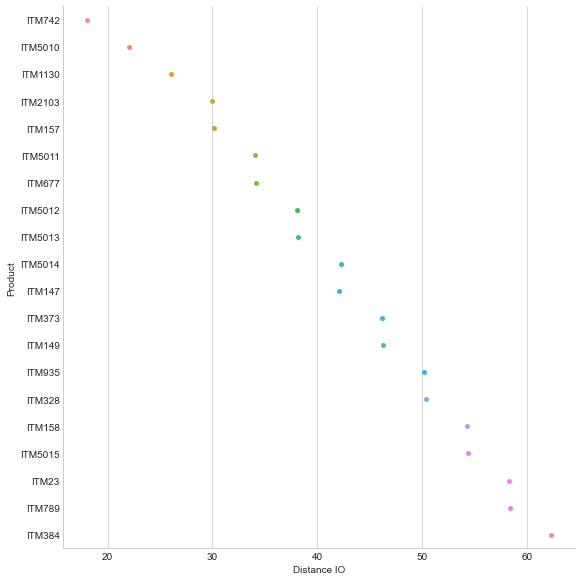

In [49]:
sns.catplot(x="Distance IO", y="Product", data=STG1_distance_df,kind='swarm', height=8, aspect=1)

## additional input for stage 2 : rules!
rules dataframe has confidence values

In [50]:
rules['antecedents'] = rules['antecedents'].astype(str)
rules['consequents'] = rules['consequents'].astype(str)

rules = rules[rules['antecedents'].isin(product)]
rules = rules[rules['consequents'].isin(product)]

In [51]:
distinctOrder_freq['MATERIAL_NUMBER'] = distinctOrder_freq['MATERIAL_NUMBER'].astype(str)

# Step 5: Run NLP model 2 - Affinity based

In [52]:
##STAGE 2
product = Products.head(No_of_Products)['MATERIAL_NUMBER'].values.tolist() #list of products
noOfPrd = len(product)
demand = dict(zip(product, [No_of_Loc_per_product]*noOfPrd)) #number of locations needed. Time being 1 per product

confidence_list = defaultdict(dict)  #confidence_list[p1][p2] will give confidence that p2 is bought for each p1
for ind, rec in rules.iterrows():
    ant = (rec['antecedents'])
    con = (rec['consequents'])
    conf = rec['confidence']
    confidence_list[ant][con]= conf

#relative order freq
order_freq = pd.Series(Products['Order Count'].values,index=Products.MATERIAL_NUMBER).to_dict()

location = locations['Location'].values.tolist()  #list of all locations
noOfLoc = len(location)
supply = dict(zip(location, 
                  [1]*noOfLoc)) #number of products that can be assigned to a location. Default 1 - one product per location

demand["DUMMY_PART"] = 0
diff = sum(supply.values()) - sum(demand.values()) #comparing supply and demand
if 'DUMMY_PART' not in product:
    product.append("DUMMY_PART") #adding dummy product as supply is more than demand
demand["DUMMY_PART"] = diff #assign these many extra locations to dummy part
order_freq["DUMMY_PART"] = 0 #no sales for dummy part

Aff_wt = 1 #to control weightage of product affinity in the optimization equation

##########################################################
#all product pairs should have confidence. If a product pair is not in input file (Apriori output), assign ZERO confidence
for p in product:  
    for c in product:
        if c not in confidence_list[p]:
            if p==c:
                confidence_list[p][c] = 1 #confidence of 1 when product pair is itself
            else:
                confidence_list[p][c] = 0 #confidence of 0 when product pair has not been purchased together (actually not > than minimum support for Apriori)
##########################################################

# instantiate Concrete Model
model = ConcreteModel()

# define variables
model.X = Var(product, location, domain=NonNegativeIntegers)

# define objective function
model.total_distance = Objective(expr=sum(order_freq[p] * distance_IO[l] * model.X[p, l]
                                     for p in product 
                                     for l in location)
                            +
                            sum(order_freq[pc] * distance_IO[lc] * model.X[pc, lc]
                                for pc in product
                                for lc in location)
                            +
                            Aff_wt *
                            sum(confidence_list[p][pc] * order_freq[p]
                                * abs(distance_BTW[l][lc]) 
                                * model.X[p, l] * model.X[pc, lc]
                                 for p in product 
                                 for l in location
                                 for pc in product
                                 for lc in location),
                            sense=minimize)

# define constraints
model.supply_ct = ConstraintList()
for l in location:
    model.supply_ct.add(
        sum(model.X[p, l] for p in product) == supply[l])

model.demand_ct = ConstraintList()
for p in product:
    model.demand_ct.add(sum(model.X[p, l] for l in location) == demand[p])

In [53]:
# solve
solver = SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 129, 'Number of variables': 2268, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 122.84534811973572}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## model 2 slotting results

In [54]:
# convert model into a Pandas data frame for nicer display
assignment = pd.DataFrame(0, index=product, columns=location)
for p in product:
    for l in location:
        assignment.loc[p, l] = model.X[p, l].value
        
for p in product:
    dmd = demand[p]
    for l in location:
        if assignment.loc[p, l] > 0.1:
            if dmd != 0:
                assignment.loc[:, l] = 0
                assignment.loc[p, l] = 1
                dmd -= 1
            else:
                assignment.loc[p, l] = 0
                
STG2_assignment = defaultdict(dict)
cols = ['Product', 'Distance']
STG2_distance_df = pd.DataFrame(columns = cols)
for p in product:
    STG2_assignment[p] = []
    for l in location:
        if assignment.loc[p, l] > 0:
            assignment.loc[p, l] = 'S'
            STG2_assignment[p] += [l]
            if p != 'DUMMY_PART':
                STG2_distance_df = STG2_distance_df.append({'Product': p, 'Distance IO':distance_IO[l]},
                                                           ignore_index=True)
        else:
            assignment.loc[p, l] = ''

# display
print(f"\nThe best distance that can be achived = {model.total_distance():,.2f}")
print("Final assignment: ")
assignment


The best distance that can be achived = 744,450.01
Final assignment: 


,50.54.A,50.53.A,50.52.A,49.54.A,50.51.A,49.53.A,50.50.A,49.52.A,50.49.A,49.51.A,...,50.04.A,49.06.A,50.03.A,49.05.A,50.02.A,49.04.A,50.01.A,49.03.A,49.02.A,49.01.A
ITM742,,,,,,,,,S,,...,,,,,,,,,,
ITM5010,S,,,,,,,,,,...,,,,,,,,,,
ITM1130,,,,,,,,,,,...,,,,,,,,,,
ITM2103,,S,,,,,,,,,...,,,,,,,,,,
ITM157,,,S,,,,,,,,...,,,,,,,,,,
ITM5011,,,,,S,,,,,,...,,,,,,,,,,
ITM677,,,,,,,,,,,...,,,,,,,,,,
ITM5012,,,,,,,,,,,...,,,,,,,,,,
ITM5013,,,,S,,,,,,,...,,,,,,,,,,
ITM5014,,,,,,,,S,,,...,,,,,,,,,,


In [55]:
assignment.to_csv('STG2_result.csv')

In [56]:
# convert model into a Pandas data frame for nicer display
assignment = pd.DataFrame(0, index=product, columns=location)
for p in product:
    for l in location:
        assignment.loc[p, l] = model.X[p, l].value
        
assignment.to_csv('STG2_result_raw.csv')

## Model 2 - product distance from drop off
Y axis: product arranged by order freq descending 

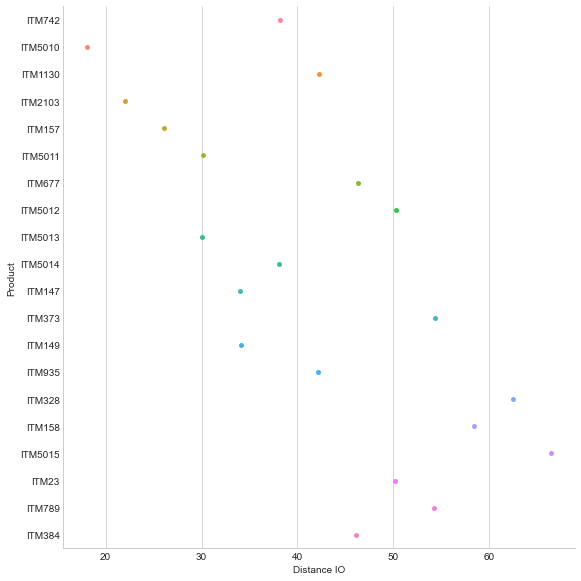

In [57]:
sns.catplot(x="Distance IO", y="Product", data=STG2_distance_df,kind='swarm', height=8, aspect=1)

## Prepare input for pick simulation

In [58]:
pick_orders = df_salesOrder[df_salesOrder['MATERIAL_NUMBER'].isin(product)]
pick_orders.drop(['SALES_ORDER_ITEM_CREATE_DATE_FISCAL_WEEK', 'SALES_ORDER_ITEM_CREATE_DATE_FISCAL_YEAR', 
                  'SALES_ORDER_ITEM','SCHEDULE_QUANTITY'], axis=1)
pick_orders = pick_orders[['MATERIAL_NUMBER', 'SALES_ORDER']].drop_duplicates()
pick_orders = pick_orders.sort_values(by=['SALES_ORDER'], ascending=True)

In [59]:
pick_orders.shape

(7813, 2)

### Total_orders_toPick

In [60]:
Total_orders_toPick = pick_orders.SALES_ORDER.nunique()
Total_orders_toPick

5054

### Total_picks

In [61]:
Total_picks = pick_orders.shape[0]
Total_picks

7813

In [62]:
order_list = pick_orders.SALES_ORDER.unique().tolist()

# Step 6:  Run picking simulation for model 1

In [63]:
stage = 'STG1'
STG_Assignment = STG1_assignment

pick_orders['Stage'] = [stage]*Total_picks
pick_orders['Location'] = ['']*Total_picks
pick_orders['Sort Field'] = [0]*Total_picks
for ind,rec in pick_orders.iterrows():
    p = rec['MATERIAL_NUMBER']
    l = STG_Assignment[p][0]
    sf = int(Locations[Locations['Location'] == l]['Sort Field'])
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Location'] = l
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Sort Field'] = sf

pick_orders = pick_orders.sort_values(by=['SALES_ORDER', 'Sort Field'], ascending=True)
pick_orders

Pick_time = pd.DataFrame(order_list, columns=['Sales Order'])
Pick_time['Stage'] = [stage] * Total_orders_toPick
Pick_time['Total Distance'] = [stage] * Total_orders_toPick
for order in order_list:
    total_dist = 0
    df = pick_orders[pick_orders['SALES_ORDER'] == order]
    first_time = True
    for ind, rec in df.iterrows():
        if first_time:
            first_time = False
            l = str(rec['Location'])
            total_dist += distance_IO[l]
            #print("first time: ",order, total_dist)
            l1 = l
            l2 = l
        else:
            l2 = str(rec['Location'])
            total_dist += abs(distance_BTW[l1][l2])
            #print("next  time: ",order, total_dist)
    total_dist += distance_IO[l2]
    #print("last  time: ",order, total_dist)
    Pick_time.loc[Pick_time['Sales Order'] == order, 'Total Distance'] = total_dist

print(Pick_time)
tot_pick_dist = Pick_time['Total Distance'].sum()
print(f"\nTotal pick distance for {stage} = {tot_pick_dist:,.2f}")

     Sales Order Stage Total Distance
0       27997929  STG1        92.3333
1       28018206  STG1        92.3333
2       28214174  STG1        76.4167
3       28319604  STG1             60
4       28349474  STG1             60
...          ...   ...            ...
5049    55875302  STG1        92.5833
5050    55875310  STG1        68.0833
5051    55875328  STG1        213.583
5052    55875348  STG1        116.833
5053    55875362  STG1             36

[5054 rows x 3 columns]

Total pick distance for STG1 = 444,402.92


In [64]:
Pick_time.to_csv('STG1_order pick times.csv')

# Step 7:  Run picking simulation for model 2

In [65]:
stage = 'STG2'
STG_Assignment = STG2_assignment

pick_orders['Stage'] = [stage]*Total_picks
pick_orders['Location'] = ['']*Total_picks
pick_orders['Sort Field'] = [0]*Total_picks
for ind,rec in pick_orders.iterrows():
    p = rec['MATERIAL_NUMBER']
    l = STG_Assignment[p][0]
    sf = int(Locations[Locations['Location'] == l]['Sort Field'])
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Location'] = l
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Sort Field'] = sf

pick_orders = pick_orders.sort_values(by=['SALES_ORDER', 'Sort Field'], ascending=True)
pick_orders

Pick_time = pd.DataFrame(order_list, columns=['Sales Order'])
Pick_time['Stage'] = [stage] * Total_orders_toPick
Pick_time['Total Distance'] = [stage] * Total_orders_toPick
for order in order_list:
    total_dist = 0
    df = pick_orders[pick_orders['SALES_ORDER'] == order]
    first_time = True
    for ind, rec in df.iterrows():
        if first_time:
            first_time = False
            l = str(rec['Location'])
            total_dist += distance_IO[l]
            #print("first time: ",order, total_dist)
            l1 = l
            l2 = l
        else:
            l2 = str(rec['Location'])
            total_dist += abs(distance_BTW[l1][l2])
            #print("next  time: ",order, total_dist)
    total_dist += distance_IO[l2]
    #print("last  time: ",order, total_dist)
    Pick_time.loc[Pick_time['Sales Order'] == order, 'Total Distance'] = total_dist

print(Pick_time)
tot_pick_dist = Pick_time['Total Distance'].sum()
print(f"\nTotal pick distance for {stage} = {tot_pick_dist:,.2f}")

     Sales Order Stage Total Distance
0       27997929  STG2         108.75
1       28018206  STG2         108.75
2       28214174  STG2             60
3       28319604  STG2        44.0833
4       28349474  STG2        44.0833
...          ...   ...            ...
5049    55875302  STG2        76.4167
5050    55875310  STG2          60.25
5051    55875328  STG2        173.292
5052    55875348  STG2          108.5
5053    55875362  STG2        76.4167

[5054 rows x 3 columns]

Total pick distance for STG2 = 420,737.67


In [66]:
Pick_time.to_csv('STG2_order pick times.csv')

# Step 8: Run NLP model 3 - Hybrid

## difference with model 2 is:    conf > .5

In [67]:
##STAGE 3
product = Products.head(No_of_Products)['MATERIAL_NUMBER'].values.tolist() #list of products
noOfPrd = len(product)
demand = dict(zip(product, [No_of_Loc_per_product]*noOfPrd)) #number of locations needed. Time being 1 per product

confidence_list = defaultdict(dict)  #confidence_list[p1][p2] will give confidence that p2 is bought for each p1
for ind, rec in rules.iterrows():
    ant = (rec['antecedents'])
    con = (rec['consequents'])
    conf = rec['confidence']
    if conf > .5:
        confidence_list[ant][con]= conf
    else:
        confidence_list[ant][con]= 0

#relative order freq
order_freq = pd.Series(Products['Order Count'].values,index=Products.MATERIAL_NUMBER).to_dict()

location = locations['Location'].values.tolist()  #list of all locations
noOfLoc = len(location)
supply = dict(zip(location, 
                  [1]*noOfLoc)) #number of products that can be assigned to a location. Default 1 - one product per location

demand["DUMMY_PART"] = 0
diff = sum(supply.values()) - sum(demand.values()) #comparing supply and demand
if 'DUMMY_PART' not in product:
    product.append("DUMMY_PART") #adding dummy product as supply is more than demand
demand["DUMMY_PART"] = diff #assign these many extra locations to dummy part
order_freq["DUMMY_PART"] = 0 #no sales for dummy part

Aff_wt = 1 #to control weightage of product affinity in the optimization equation

##########################################################
#all product pairs should have confidence. If a product pair is not in input file (Apriori output), assign ZERO confidence
for p in product:  
    for c in product:
        if c not in confidence_list[p]:
            if p==c:
                confidence_list[p][c] = 1 #confidence of 1 when product pair is itself
            else:
                confidence_list[p][c] = 0 #confidence of 0 when product pair has not been purchased together (actually not > than minimum support for Apriori)
##########################################################

# instantiate Concrete Model
model = ConcreteModel()

# define variables
model.X = Var(product, location, domain=NonNegativeIntegers)

# define objective function
model.total_distance = Objective(expr=sum(order_freq[p] * distance_IO[l] * model.X[p, l]
                                     for p in product 
                                     for l in location)
                            +
                            sum(order_freq[pc] * distance_IO[lc] * model.X[pc, lc]
                                for pc in product
                                for lc in location)
                            +
                            Aff_wt *
                            sum(confidence_list[p][pc] * order_freq[p]
                                * abs(distance_BTW[l][lc]) 
                                * model.X[p, l] * model.X[pc, lc]
                                 for p in product 
                                 for l in location
                                 for pc in product
                                 for lc in location),
                            sense=minimize)

# define constraints
model.supply_ct = ConstraintList()
for l in location:
    model.supply_ct.add(
        sum(model.X[p, l] for p in product) == supply[l])

model.demand_ct = ConstraintList()
for p in product:
    model.demand_ct.add(sum(model.X[p, l] for l in location) == demand[p])

In [68]:
# solve
solver = SolverFactory('ipopt')
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 129, 'Number of variables': 2268, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 23.875860929489136}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Model 3 slotting results

In [69]:
# convert model into a Pandas data frame for nicer display
assignment = pd.DataFrame(0, index=product, columns=location)
for p in product:
    for l in location:
        assignment.loc[p, l] = model.X[p, l].value
        
for p in product:
    dmd = demand[p]
    for l in location:
        if assignment.loc[p, l] > 0.1:
            if dmd != 0:
                assignment.loc[:, l] = 0
                assignment.loc[p, l] = 1
                dmd -= 1
            else:
                assignment.loc[p, l] = 0
                
STG3_assignment = defaultdict(dict)
cols = ['Product', 'Distance']
STG3_distance_df = pd.DataFrame(columns = cols)
for p in product:
    STG3_assignment[p] = []
    for l in location:
        if assignment.loc[p, l] > 0:
            assignment.loc[p, l] = 'S'
            STG3_assignment[p] += [l]
            if p != 'DUMMY_PART':
                STG3_distance_df = STG3_distance_df.append({'Product': p, 'Distance IO':distance_IO[l]},
                                                           ignore_index=True)
        else:
            assignment.loc[p, l] = ''

# display
print(f"\nThe best distance that can be achived = {model.total_distance():,.2f}")
print("Final assignment: ")
assignment


The best distance that can be achived = 611,096.06
Final assignment: 


,50.54.A,50.53.A,50.52.A,49.54.A,50.51.A,49.53.A,50.50.A,49.52.A,50.49.A,49.51.A,...,50.04.A,49.06.A,50.03.A,49.05.A,50.02.A,49.04.A,50.01.A,49.03.A,49.02.A,49.01.A
ITM742,S,,,,,,,,,,...,,,,,,,,,,
ITM5010,,S,,,,,,,,,...,,,,,,,,,,
ITM1130,,,,,S,,,,,,...,,,,,,,,,,
ITM2103,,,S,,,,,,,,...,,,,,,,,,,
ITM157,,,,S,,,,,,,...,,,,,,,,,,
ITM5011,,,,,,S,,,,,...,,,,,,,,,,
ITM677,,,,,,,,,,S,...,,,,,,,,,,
ITM5012,,,,,,,,,,,...,,,,,,,,,,
ITM5013,,,,,,,S,,,,...,,,,,,,,,,
ITM5014,,,,,,,,,S,,...,,,,,,,,,,


In [70]:
assignment.to_csv('STG3_result.csv')

In [71]:
# convert model into a Pandas data frame for nicer display
assignment = pd.DataFrame(0, index=product, columns=location)
for p in product:
    for l in location:
        assignment.loc[p, l] = model.X[p, l].value
        
assignment.to_csv('STG3_result_raw.csv')

## Model 3 - product distance from drop off
Y axis: product arranged by order freq descending 

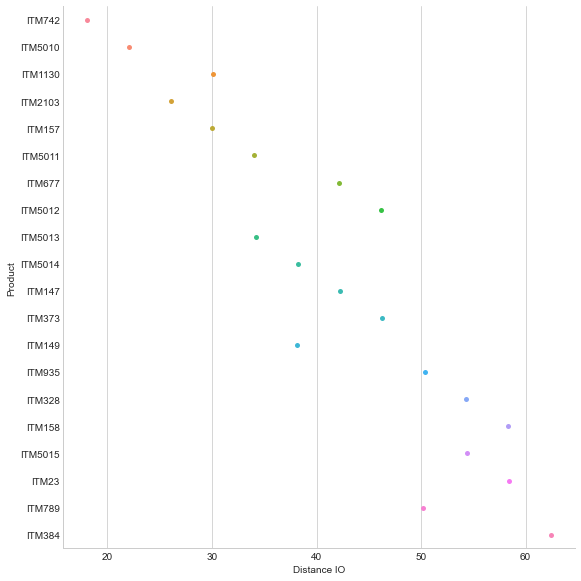

In [72]:
sns.catplot(x="Distance IO", y="Product", data=STG3_distance_df,kind='swarm', height=8, aspect=1)

# Step 9 : Run picking simulation for model 3

In [73]:
stage = 'STG3'
STG_Assignment = STG3_assignment

pick_orders['Stage'] = [stage]*Total_picks
pick_orders['Location'] = ['']*Total_picks
pick_orders['Sort Field'] = [0]*Total_picks
for ind,rec in pick_orders.iterrows():
    p = rec['MATERIAL_NUMBER']
    l = STG_Assignment[p][0]
    sf = int(Locations[Locations['Location'] == l]['Sort Field'])
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Location'] = l
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Sort Field'] = sf

pick_orders = pick_orders.sort_values(by=['SALES_ORDER', 'Sort Field'], ascending=True)
pick_orders

Pick_time = pd.DataFrame(order_list, columns=['Sales Order'])
Pick_time['Stage'] = [stage] * Total_orders_toPick
Pick_time['Total Distance'] = [stage] * Total_orders_toPick
for order in order_list:
    total_dist = 0
    df = pick_orders[pick_orders['SALES_ORDER'] == order]
    first_time = True
    for ind, rec in df.iterrows():
        if first_time:
            first_time = False
            l = str(rec['Location'])
            total_dist += distance_IO[l]
            #print("first time: ",order, total_dist)
            l1 = l
            l2 = l
        else:
            l2 = str(rec['Location'])
            total_dist += abs(distance_BTW[l1][l2])
            #print("next  time: ",order, total_dist)
    total_dist += distance_IO[l2]
    #print("last  time: ",order, total_dist)
    Pick_time.loc[Pick_time['Sales Order'] == order, 'Total Distance'] = total_dist

print(Pick_time)
tot_pick_dist = Pick_time['Total Distance'].sum()
print(f"\nTotal pick distance for {stage} = {tot_pick_dist:,.2f}")

     Sales Order Stage Total Distance
0       27997929  STG3        92.5833
1       28018206  STG3        92.5833
2       28214174  STG3        68.3333
3       28319604  STG3        52.1667
4       28349474  STG3        52.1667
...          ...   ...            ...
5049    55875302  STG3        76.1667
5050    55875310  STG3        68.0833
5051    55875328  STG3        197.167
5052    55875348  STG3        100.417
5053    55875362  STG3             36

[5054 rows x 3 columns]

Total pick distance for STG3 = 443,497.67


In [74]:
Pick_time.to_csv('STG3_order pick times.csv')

# Step 10: Import AS-IS warehouse product arrangement

In [75]:
Current_WH_loc_assignment = pd.read_excel('Input Data/Current Material Location.XLSX')

/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/Users/shyamsrikumar/opt/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


## Current WH product:location assignment

In [76]:
Current_WH_loc_assignment = Current_WH_loc_assignment.sort_values(by=['Storage Bin'], ascending=False)
current_assignment = Current_WH_loc_assignment[~Current_WH_loc_assignment.isnull().any(axis=1)]
current_assignment

,Storage Bin,level,Material
3716,50.51.D,D,ITM866
10829,50.51.C,C,ITM4591
10546,50.51.B,B,ITM4402
1377,50.51.A,A,ITM5015
3715,50.50.D,D,ITM865
...,...,...,...
9632,01.21.C,C,ITM3981
3194,01.05.B,B,ITM434
8515,01.01.D,D,ITM3256
8412,01.01.C,C,ITM3195


## Current WH unassigned locations

In [77]:
Unassigned_locations = Current_WH_loc_assignment[Current_WH_loc_assignment.isnull().any(axis=1)]
Unassigned_locations = Unassigned_locations[(Unassigned_locations['level'] == 'A')|(Unassigned_locations['level'] == 'B')]
Unassigned_locations

,Storage Bin,level,Material
1387,50.54.B,B,NaN
1386,50.54.A,A,NaN
1383,50.53.B,B,NaN
1382,50.53.A,A,NaN
1379,50.52.B,B,NaN
...,...,...,...
2089,01.03.B,B,NaN
2088,01.03.A,A,NaN
2085,01.02.B,B,NaN
2084,01.02.A,A,NaN


## For products not available in WH, ie. no location assigned. Assign the best unassigned location to that product

In [78]:
STG0_assignment = defaultdict(dict)
for p in product:
    STG0_assignment[p] = []

for ind, rec in current_assignment.iterrows():
    p = rec['Material']
    l = rec['Storage Bin']
    if p in product:
        STG0_assignment[p] += [l]

for p in product:
    l = STG0_assignment[p]
    if len(l) == 0:
        l1 = Unassigned_locations['Storage Bin'].iat[0]
        STG0_assignment[p] = [l1]
        Current_WH_loc_assignment.loc[Current_WH_loc_assignment['Storage Bin'] == l1, 'Material'] = p
        Unassigned_locations = Current_WH_loc_assignment[Current_WH_loc_assignment.isnull().any(axis=1)]
        Unassigned_locations = Unassigned_locations[(Unassigned_locations['level'] == 'A')|(Unassigned_locations['level'] == 'B')]   
        

## Current WH product:loc assignment dictionary

In [79]:
STG0_assignment

defaultdict(dict,
            {'ITM742': ['43.54.A'],
             'ITM5010': ['50.01.A'],
             'ITM1130': ['49.13.A'],
             'ITM2103': ['37.32.A'],
             'ITM157': ['29.11.A'],
             'ITM5011': ['50.22.A', '50.21.A'],
             'ITM677': ['50.36.C'],
             'ITM5012': ['50.31.A'],
             'ITM5013': ['50.32.A'],
             'ITM5014': ['50.50.A', '50.35.A'],
             'ITM147': ['49.32.D',
              '49.31.D',
              '30.16.C',
              '30.14.C',
              '29.25.C',
              '27.03.A'],
             'ITM373': ['48.37.B'],
             'ITM149': ['42.51.A', '27.24.A'],
             'ITM935': ['42.44.D'],
             'ITM328': ['47.04.D'],
             'ITM158': ['40.29.B', '29.32.A'],
             'ITM5015': ['50.51.A'],
             'ITM23': ['48.19.A',
              '48.09.A',
              '47.25.A',
              '43.13.A',
              '28.05.A',
              '28.02.A',
              '28.01.A'],
        

## build loc to loc matrix again (using all locations in the WH)

In [80]:
location = Locations['Location'].values.tolist()

same_aisle = [{50,49},{48,47},{46,45},{44,43},{42,41},{40,39},{38,37},{36,35},
              {34,33},{32,31},{30,29},{28,27},{26,25},{24,23},{22,21},{20,19},
              {18,17},{16,15},{14,13},{12,11},{10,9},{8,7},{6,5},{4,3},{2,1}]
distance_Pick = pd.Series(Locations['Final Pick Distance'].values,index=Locations.Location).to_dict()
distance_IO = pd.Series(Locations['Final distance to drop off'].values,index=Locations.Location).to_dict()
distance_BTW = defaultdict(dict)
for l1 in location:
    distance_BTW[l1] = defaultdict(dict)
    for l2 in location:
        a1 = int(l1[:2])
        a2 = int(l2[:2])
        if {a1,a2} in same_aisle:
            if a1 > a2:
                d1 = distance_Pick[l1]
                d2 = distance_Pick[l2] - 12
            else:
                d1 = distance_Pick[l1] - 12
                d2 = distance_Pick[l2]
            distance_BTW[l1][l2] = abs(d1-d2) + 12
        else:
            distance_BTW[l1][l2] = abs(distance_Pick[l1] - distance_Pick[l2])

#list(distance_BTW.items())[:1]

# Step 11: Run picking simulation for AS-IS

In [81]:
stage = 'STG0'
STG_Assignment = STG0_assignment

pick_orders['Stage'] = [stage]*Total_picks
pick_orders['Location'] = ['']*Total_picks
pick_orders['Sort Field'] = [0]*Total_picks
for ind,rec in pick_orders.iterrows():
    p = rec['MATERIAL_NUMBER']
    l = STG_Assignment[p][0]
    sf = int(Locations[Locations['Location'] == l]['Sort Field'])
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Location'] = l
    pick_orders.loc[pick_orders['MATERIAL_NUMBER'] == p, 'Sort Field'] = sf

pick_orders = pick_orders.sort_values(by=['SALES_ORDER', 'Sort Field'], ascending=True)
pick_orders

Pick_time = pd.DataFrame(order_list, columns=['Sales Order'])
Pick_time['Stage'] = [stage] * Total_orders_toPick
Pick_time['Total Distance'] = [stage] * Total_orders_toPick
for order in order_list:
    total_dist = 0
    df = pick_orders[pick_orders['SALES_ORDER'] == order]
    first_time = True
    for ind, rec in df.iterrows():
        if first_time:
            first_time = False
            l = str(rec['Location'])
            total_dist += distance_IO[l]
            #print("first time: ",order, total_dist)
            l1 = l
            l2 = l
        else:
            l2 = str(rec['Location'])
            total_dist += abs(distance_BTW[l1][l2])
            #print("next  time: ",order, total_dist)
    total_dist += distance_IO[l2]
    #print("last  time: ",order, total_dist)
    Pick_time.loc[Pick_time['Sales Order'] == order, 'Total Distance'] = total_dist

print(Pick_time)
tot_pick_dist = Pick_time['Total Distance'].sum()
print(f"\nTotal pick distance for {stage} = {tot_pick_dist:,.2f}")

     Sales Order Stage Total Distance
0       27997929  STG0        252.417
1       28018206  STG0        252.417
2       28214174  STG0        213.833
3       28319604  STG0        489.833
4       28349474  STG0        489.833
...          ...   ...            ...
5049    55875302  STG0         228.25
5050    55875310  STG0        312.583
5051    55875328  STG0        2333.17
5052    55875348  STG0        1054.96
5053    55875362  STG0            186

[5054 rows x 3 columns]

Total pick distance for STG0 = 3,568,043.00


In [82]:
Pick_time.to_csv('STG0_order pick times.csv')

## combine all the pick times from model 1, 2, 3 and as-is  simulation runs

In [83]:
df0 = pd.read_csv('STG0_order pick times.csv')
df1 = pd.read_csv('STG1_order pick times.csv')
df2 = pd.read_csv('STG2_order pick times.csv')
df3 = pd.read_csv('STG3_order pick times.csv')

# Step 12: Compare models 1, 2, 3 and AS-IS   

In [84]:
df = pd.concat([df0, df1, df2, df3])
df.rename(columns = {'Unnamed: 0':'Index'}, inplace = True)
df.rename(columns = {'Sales Order':'SALES_ORDER'}, inplace = True)
df.loc[df['Stage'] == 'STG0', 'Stage'] = 'AS-IS'
df.loc[df['Stage'] == 'STG1', 'Stage'] = 'Popularity Based'
df.loc[df['Stage'] == 'STG2', 'Stage'] = 'Affinity Based'
df.loc[df['Stage'] == 'STG3', 'Stage'] = 'Hybrid'

In [85]:
df1 = df_salesOrder[df_salesOrder['MATERIAL_NUMBER'].isin(product)][['MATERIAL_NUMBER', 'SALES_ORDER']].drop_duplicates()
df2 = df1.groupby('SALES_ORDER')['MATERIAL_NUMBER'].agg(No_of_Lines='count').reset_index()
df2.loc[df2['No_of_Lines'] == 1, 'Single or Multiple'] = 'Single'
df2.loc[df2['No_of_Lines'] > 1, 'Single or Multiple'] = 'Multiple'

In [86]:
df['SALES_ORDER'] = df['SALES_ORDER'].astype(str)
df2['SALES_ORDER'] = df2['SALES_ORDER'].astype(str)
Run_Results = pd.merge(df, df2, on="SALES_ORDER", how="left")
Run_Results.reset_index()
Run_Results

,Index,SALES_ORDER,Stage,Total Distance,No_of_Lines,Single or Multiple
0,0,27997929,AS-IS,252.416667,1,Single
1,1,28018206,AS-IS,252.416667,1,Single
2,2,28214174,AS-IS,213.833333,1,Single
3,3,28319604,AS-IS,489.833333,1,Single
4,4,28349474,AS-IS,489.833333,1,Single
...,...,...,...,...,...,...
20211,5049,55875302,Hybrid,76.166667,2,Multiple
20212,5050,55875310,Hybrid,68.083333,1,Single
20213,5051,55875328,Hybrid,197.166667,7,Multiple
20214,5052,55875348,Hybrid,100.416667,2,Multiple


## Comparing total distance

In [87]:
Run_Results.groupby('Stage').agg({'Total Distance':'sum', 'SALES_ORDER': 'count'})

,Total Distance,SALES_ORDER
Stage,,
AS-IS,3.568043e+06,5054
Affinity Based,4.207377e+05,5054
Hybrid,4.434977e+05,5054
Popularity Based,4.444029e+05,5054


## Comparing total distance for single and multiple orders

In [88]:
Run_Results.groupby(['Stage','Single or Multiple']).agg({'Total Distance':'sum', 'SALES_ORDER': 'count'})

Total Distance  SALES_ORDER
Stage            Single or Multiple                             
AS-IS            Multiple              2.208569e+06         1419
                 Single                1.359474e+06         3635
Affinity Based   Multiple              1.525973e+05         1419
                 Single                2.681403e+05         3635
Hybrid           Multiple              1.689155e+05         1419
                 Single                2.745822e+05         3635
Popularity Based Multiple              1.677094e+05         1419
                 Single                2.766935e+05         3635

In [89]:
# Python code to get the Cumulative sum of a list
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

## Cumulative Distance Traveled - Model 1 vs 2 vs 3

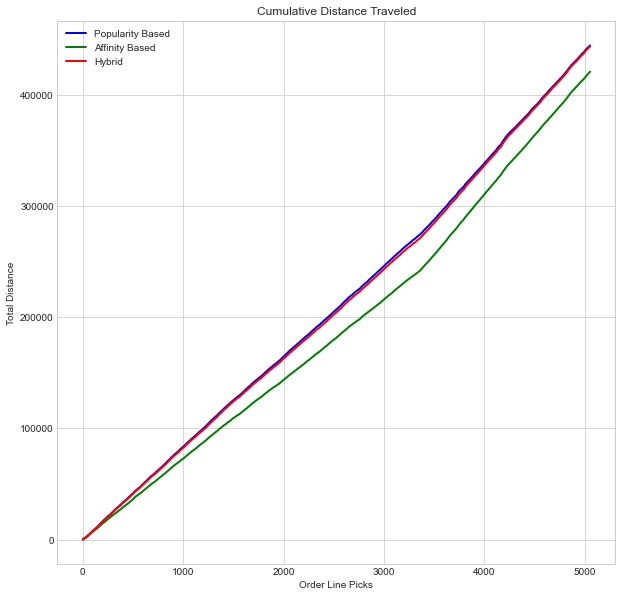

In [90]:
x = Run_Results.loc[Run_Results['Stage'] == 'AS-IS']['Index']
y1 = Run_Results.loc[Run_Results['Stage'] == 'AS-IS']['Total Distance']
y1 = Cumulative(y1)

y2 = Run_Results.loc[Run_Results['Stage'] == 'Popularity Based']['Total Distance']
y2 = Cumulative(y2)

y3 = Run_Results.loc[Run_Results['Stage'] == 'Affinity Based']['Total Distance']
y3 = Cumulative(y3)

y4 = Run_Results.loc[Run_Results['Stage'] == 'Hybrid']['Total Distance']
y4 = Cumulative(y4)

plt.rcParams["figure.figsize"] = (10,10)

#plt.plot(x,y1)
plt.plot(x,y2, color = "blue", linewidth=2)
plt.plot(x,y3, color = "green", linewidth=2)
plt.plot(x,y4, color = "red", linewidth=2)
plt.title('Cumulative Distance Traveled')
plt.xlabel('Order Line Picks')
plt.ylabel('Total Distance')
plt.gca().legend(('Popularity Based','Affinity Based','Hybrid'))
plt.show()

## Cumulative Distance Traveled - Model 1 vs 2 vs 3 vs AS-IS

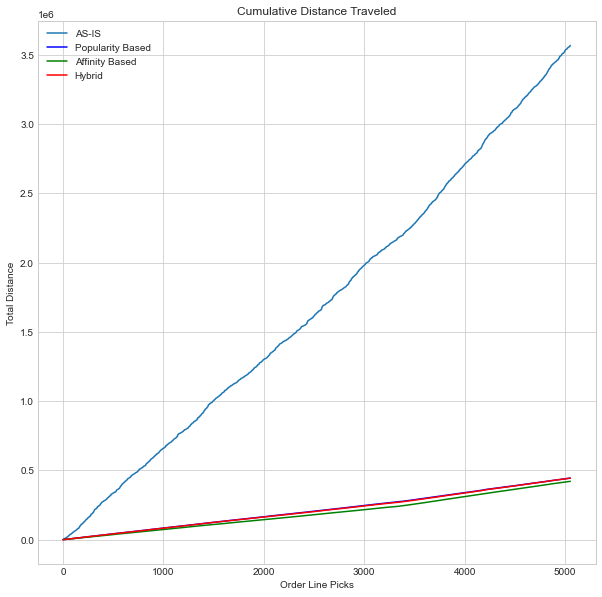

In [91]:
x = Run_Results.loc[Run_Results['Stage'] == 'AS-IS']['Index']
y1 = Run_Results.loc[Run_Results['Stage'] == 'AS-IS']['Total Distance']
y1 = Cumulative(y1)

y2 = Run_Results.loc[Run_Results['Stage'] == 'Popularity Based']['Total Distance']
y2 = Cumulative(y2)

y3 = Run_Results.loc[Run_Results['Stage'] == 'Affinity Based']['Total Distance']
y3 = Cumulative(y3)

y4 = Run_Results.loc[Run_Results['Stage'] == 'Hybrid']['Total Distance']
y4 = Cumulative(y4)

plt.plot(x,y1)
plt.plot(x,y2, color = "blue")
plt.plot(x,y3, color = "green")
plt.plot(x,y4, color = "red")
plt.title('Cumulative Distance Traveled')
plt.xlabel('Order Line Picks')
plt.ylabel('Total Distance')
plt.gca().legend(('AS-IS','Popularity Based','Affinity Based','Hybrid'))
plt.show()